# Regridding WOA data
In this notebook, we show a basic data analysis worfklow using data from the [FishMIP Input Explorer](https://rstudio.global-ecosystem-model.cloud.edu.au/shiny/FishMIP_Input_Explorer/) in Python. You will learn the following:
1. How to load a `zarr` file using `xarray`  
2. How to subset data temporally and calculate a temporal mean  
3. How to create a `Data Array` from a `data frame`  
4. How to interpolate data along the `depth` dimension  
5. How to regrid a `Data Array` to match the grid of another dataset  
6. How to save `Data Arrays` as gridded and tabular data  

To use this notebook, you will need to have downloaded GFDL and WOA data from our [shiny app](https://rstudio.global-ecosystem-model.cloud.edu.au/shiny/FishMIP_Input_Explorer/). Note that data has to be for the same regional model, but it does not need to be for the same variable as we are only interested in the grids.  

Make sure you update the file paths where you have saved the data. Make sure you provide the full path, not only the file name.

# Load libraries

In [1]:
import xarray as xr
import pandas as pd
import xesmf as xe

# Load GFDL `zarr` file

In [3]:
#Define location of GFDL data
gfdl_path = 'full_file_path_to_gfdl_zarr_data'
gfdl = xr.open_zarr(gfdl_path)
gfdl

<xarray.Dataset> Size: 100MB
Dimensions:      (time: 600, depth_bin_m: 35, lat: 36, lon: 33)
Coordinates:
  * depth_bin_m  (depth_bin_m) float64 280B 2.5 10.0 20.0 ... 6e+03 6.5e+03
  * lat          (lat) float64 288B 64.38 64.12 63.88 ... 56.12 55.88 55.62
  * lon          (lon) float64 264B 15.62 15.88 16.12 ... 23.12 23.38 23.62
  * time         (time) datetime64[ns] 5kB 1961-01-01 1961-02-01 ... 2010-12-01
Data variables:
    chl          (time, depth_bin_m, lat, lon) float32 100MB dask.array<chunksize=(600, 5, 36, 33), meta=np.ndarray>

# Calculate climatological mean
For this example, we will use 10 years of data (1991-2000) to calculate a climatological mean. Note that you will need to know the name of the variable in your `Dataset`. In the example above, under *Data variables*, we can see that there is only one variable: *chl*. We will need to call this variable before we can calculate the mean.

**Note:** If you use a different variable, make sure you use the name of the variable you are loading. Check the information provided in the metadata for your file.

In [4]:
gfdl = gfdl.chl
gfdl

<xarray.DataArray 'chl' (time: 600, depth_bin_m: 35, lat: 36, lon: 33)> Size: 100MB
dask.array<open_dataset-chl, shape=(600, 35, 36, 33), dtype=float32, chunksize=(600, 5, 36, 33), chunktype=numpy.ndarray>
Coordinates:
  * depth_bin_m  (depth_bin_m) float64 280B 2.5 10.0 20.0 ... 6e+03 6.5e+03
  * lat          (lat) float64 288B 64.38 64.12 63.88 ... 56.12 55.88 55.62
  * lon          (lon) float64 264B 15.62 15.88 16.12 ... 23.12 23.38 23.62
  * time         (time) datetime64[ns] 5kB 1961-01-01 1961-02-01 ... 2010-12-01
Attributes:
    GFDL_variable:  chl
    long_name:      Mass Concentration of Total Phytoplankton expressed as Ch...
    standard_name:  mass_concentration_of_phytoplankton_expressed_as_chloroph...
    units:          kg m-3

We now have a `Data Array` of the variable we selected (`chl`). Now we can select the years of our interest and calculate the mean across time.

In [5]:
gfdl_mean = gfdl.sel(time = slice('1991', '2000')).mean('time')
gfdl_mean

<xarray.DataArray 'chl' (depth_bin_m: 35, lat: 36, lon: 33)> Size: 166kB
dask.array<mean_agg-aggregate, shape=(35, 36, 33), dtype=float32, chunksize=(5, 36, 33), chunktype=numpy.ndarray>
Coordinates:
  * depth_bin_m  (depth_bin_m) float64 280B 2.5 10.0 20.0 ... 6e+03 6.5e+03
  * lat          (lat) float64 288B 64.38 64.12 63.88 ... 56.12 55.88 55.62
  * lon          (lon) float64 264B 15.62 15.88 16.12 ... 23.12 23.38 23.62

You will notice that the `time` dimension disappeared, but we still have 35 depth levels. We can plot the first depth level to see what our data looks like. Note that this time we will use `isel`, which allows us to use an index to select data.

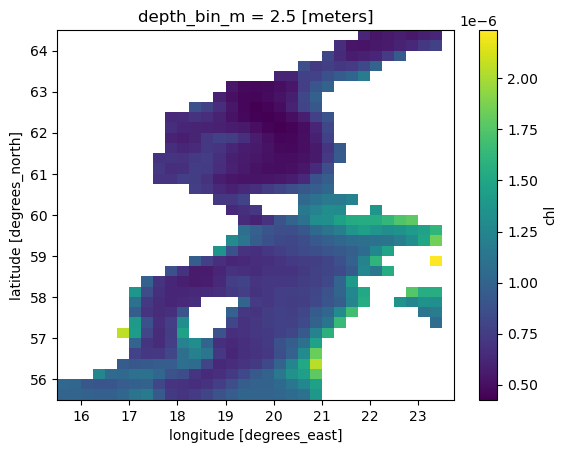

In [7]:
gfdl_mean.isel(depth_bin_m = 0).plot()

# Loading WOA data
We made the WOA data available as `parquet` files in our shiny app, so we will not be able to load it using the `xarray` package as we did with the `zarr` file. Instead, we will load it as a data frame with `pandas` and transform it to a `Data Array`.

In [8]:
#Define location of GFDL data
woa_path = 'full_file_path_to_woa_parquet_data'
woa = pd.read_parquet(woa_path)
woa.head()

,lat,lon,depth,vals,cell_methods,long_name,standard_name,units
0,55.625,15.625,0.0,7.35091,area: mean depth: mean time: mean within years...,Objectively analyzed mean fields for sea_water...,sea_water_practical_salinity,1
1,55.625,15.875,0.0,7.36619,None,None,None,None
2,55.625,16.125,0.0,7.37479,None,None,None,None
3,55.625,16.375,0.0,7.38169,None,None,None,None
4,55.625,16.625,0.0,7.37289,None,None,None,None


We will drop the columns after `vals` because we will not need them here.

In [115]:
woa = woa[['lat', 'lon', 'depth', 'vals']]
woa.head()

,lat,lon,depth,vals
0,55.625,15.625,0.0,7.35091
1,55.625,15.875,0.0,7.36619
2,55.625,16.125,0.0,7.37479
3,55.625,16.375,0.0,7.38169
4,55.625,16.625,0.0,7.37289


We will now "complete" our dataset by ensuring we have all possible combinations of `lat` and `lon`.

In [116]:
woa = woa.pivot(index = ['depth', 'lon'], columns = 'lat', values = 'vals')
woa.head()

lat            55.625   55.875   56.125  56.375  56.625  56.875   57.125  \
depth lon                                                                  
0.0   15.625  7.35091  7.25600      NaN     NaN     NaN     NaN      NaN   
      15.875  7.36619  7.28809      NaN     NaN     NaN     NaN      NaN   
      16.125  7.37479  7.30711  7.25431     NaN     NaN     NaN      NaN   
      16.375  7.38169  7.30849  7.25761     NaN     NaN     NaN      NaN   
      16.625  7.37289  7.29879  7.23289     NaN     NaN     NaN  7.60819   

lat           57.375  57.625  57.875  ...  62.125  62.375  62.625  62.875  \
depth lon                             ...                                   
0.0   15.625     NaN     NaN     NaN  ...     NaN     NaN     NaN     NaN   
      15.875     NaN     NaN     NaN  ...     NaN     NaN     NaN     NaN   
      16.125     NaN     NaN     NaN  ...     NaN     NaN     NaN     NaN   
      16.375     NaN     NaN     NaN  ...     NaN     NaN     NaN     NaN   
      16.625     NaN     NaN     NaN  ...     NaN     NaN     NaN     NaN   

lat           63.125  63.375  63.625  63.875  64.125  64.375  
depth lon                                                     
0.0   15.625     NaN     NaN     NaN     NaN     NaN     NaN  
      15.875     NaN     NaN     NaN     NaN     NaN     NaN  
      16.125     NaN     NaN     NaN     NaN     NaN     NaN  
      16.375     NaN     NaN     NaN     NaN     NaN     NaN  
      16.625     NaN     NaN     NaN     NaN     NaN     NaN  

[5 rows x 36 columns]

This is looking more like a grid now and we have `NaN` for grid cells outside our area of interest, but now we need to "complete" the `depth` dimension. So, we will return the data frame to a long format and complete our data frame along this last dimension.

In [152]:
woa = woa.melt(value_name = 'vals', ignore_index = False).reset_index().sort_values(['depth', 'lat', 'lon'])
woa = woa.pivot(index = 'depth', columns = ['lat', 'lon'], values = 'vals')
woa

lat       55.625                                                               \
lon       15.625     15.875     16.125     16.375    16.625   16.875   17.125   
depth                                                                           
0.0     7.350910   7.366190   7.374790   7.381690   7.37289  7.36381  7.34959   
5.0     7.349290   7.374600   7.395590   7.405100   7.39740  7.38879  7.37421   
10.0    7.352490   7.373810   7.400800   7.403790   7.39810  7.39009  7.37619   
15.0    7.335110   7.352700   7.377610   7.392110   7.38841  7.38271  7.37141   
20.0    7.360610   7.367490   7.387210   7.397110   7.38509  7.38580  7.38049   
25.0    7.403210   7.383310   7.400600   7.405010   7.39421  7.40720  7.40691   
30.0    7.621500   7.555590   7.520590   7.492110   7.46349  7.44911  7.43089   
35.0    7.665100   7.579210   7.536910   7.501010   7.48101  7.46891  7.45031   
40.0    7.797590   7.657990   7.571410   7.518210   7.48951  7.47709      NaN   
45.0    8.241509   7.987690   7.791790   7.640790   7.54879      NaN      NaN   
50.0    9.254910   9.032109   8.752509   8.485009   8.27779      NaN      NaN   
55.0   10.936709  10.519400   9.950590   9.578910   9.28979      NaN      NaN   
60.0   12.782310  12.226009  11.449209  10.970700  10.52481      NaN      NaN   
65.0   13.999300  13.426991  12.687791  11.921800       NaN      NaN      NaN   
70.0   15.100309  14.545509  13.811910  13.042690       NaN      NaN      NaN   
75.0         NaN  15.480610  14.399091  13.483590       NaN      NaN      NaN   
80.0         NaN        NaN        NaN        NaN       NaN      NaN      NaN   
85.0         NaN        NaN        NaN        NaN       NaN      NaN      NaN   
90.0         NaN        NaN        NaN        NaN       NaN      NaN      NaN   
95.0         NaN        NaN        NaN        NaN       NaN      NaN      NaN   
100.0        NaN        NaN        NaN        NaN       NaN      NaN      NaN   
125.0        NaN        NaN        NaN        NaN       NaN      NaN      NaN   
150.0        NaN        NaN        NaN        NaN       NaN      NaN      NaN   
175.0        NaN        NaN        NaN        NaN       NaN      NaN      NaN   
200.0        NaN        NaN        NaN        NaN       NaN      NaN      NaN   
225.0        NaN        NaN        NaN        NaN       NaN      NaN      NaN   

lat                                ... 64.375                             \
lon     17.375   17.625    17.875  ... 21.375   21.625   21.875   22.125   
depth                              ...                                     
0.0    7.33211  7.30961   7.28469  ...    NaN  4.99969  5.00811  5.00219   
5.0    7.35011  7.32981   7.31021  ...    NaN  5.00000  5.00279  5.00359   
10.0   7.36139  7.32441   7.29481  ...    NaN  5.00041  5.00449  5.00561   
15.0   7.35341  7.33070   7.29571  ...    NaN  5.00361  5.01039  5.01529   
20.0   7.36111  7.32740   7.28491  ...    NaN  5.00859  5.01569  5.01730   
25.0   7.38489  7.34729   7.30179  ...    NaN      NaN  5.01541  5.02239   
30.0       NaN  7.44391   7.41571  ...    NaN      NaN  5.01350  5.02131   
35.0       NaN  7.50060   7.47371  ...    NaN      NaN  5.01339  5.02129   
40.0       NaN      NaN   7.57609  ...    NaN      NaN  5.01519  5.02090   
45.0       NaN      NaN   7.73751  ...    NaN      NaN  5.01681  5.02119   
50.0       NaN      NaN   8.09749  ...    NaN      NaN  5.01920  5.02129   
55.0       NaN      NaN   8.64879  ...    NaN      NaN  5.01729  5.02319   
60.0       NaN      NaN   9.37381  ...    NaN      NaN  5.01909  5.02509   
65.0       NaN      NaN  10.37161  ...    NaN      NaN  5.01899  5.02511   
70.0       NaN      NaN       NaN  ...    NaN      NaN  5.03371  5.03590   
75.0       NaN      NaN       NaN  ...    NaN      NaN  5.04089  5.04101   
80.0       NaN      NaN       NaN  ...    NaN      NaN  5.04179  5.04189   
85.0       NaN      NaN       NaN  ...    NaN      NaN  5.04431  5.04571   
90.0       NaN      NaN       NaN  ...    NaN      NaN

This is exactly what we needed. The data frame now has all possible combinations of `depth`, `lat` and `lon`. We will turn it back to the long format, and sort them by `depth` and coordinates.

In [153]:
woa = woa.melt(value_name = 'vals', ignore_index = False).reset_index().sort_values(['depth', 'lat', 'lon'])
woa.head()

,depth,lat,lon,vals
0,0.0,55.625,15.625,7.35091
26,0.0,55.625,15.875,7.36619
52,0.0,55.625,16.125,7.37479
78,0.0,55.625,16.375,7.38169
104,0.0,55.625,16.625,7.37289


We can get unique values for our dimensions, which we will use when creating the `Data Array`.

In [172]:
depth = pd.unique(woa.depth)
lon = pd.unique(woa.lon)
lat = pd.unique(woa.lat)

We will use the length of these unique values to reshape our data.

In [156]:
woa_vals = woa.vals.values.reshape((len(depth), 36, 33))
woa_vals.shape

(26, 36, 33)

Now we have everything we need to create our `Data Array`.

In [185]:
woa_da = xr.DataArray(data = woa_vals, dims = ['depth_bin_m', 'lat', 'lon'],
                      coords = {'lon': lon, 'lat': lat, 'depth_bin_m': depth})
woa_da

<xarray.DataArray (depth_bin_m: 26, lat: 36, lon: 33)> Size: 124kB
array([[[7.35091  , 7.36619  , 7.37479  , ...,       nan,       nan,
               nan],
        [7.256    , 7.2880898, 7.30711  , ...,       nan,       nan,
               nan],
        [      nan,       nan, 7.25431  , ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ..., 4.99979  , 4.99979  ,
               nan],
        [      nan,       nan,       nan, ..., 5.00019  , 4.99969  ,
               nan]],

       [[7.34929  , 7.3746   , 7.39559  , ...,       nan,       nan,
               nan],
        [7.25341  , 7.29269  , 7.33349  , ...,       nan,       nan,
               nan],
        [      nan,       nan, 7.29359  , ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * lon          (lon) float32 132B 15.62 15.88 16.12 ... 23.12 23.38 23.62
  * lat          (lat) float64 288B 55.62 55.88 56.12 ... 63.88 64.12 64.38
  * depth_bin_m  (depth_bin_m) float32 104B 0.0 5.0 10.0 ... 175.0 200.0 225.0

We can check we have created the `Data Array` correctly by plotting the first depth bin.

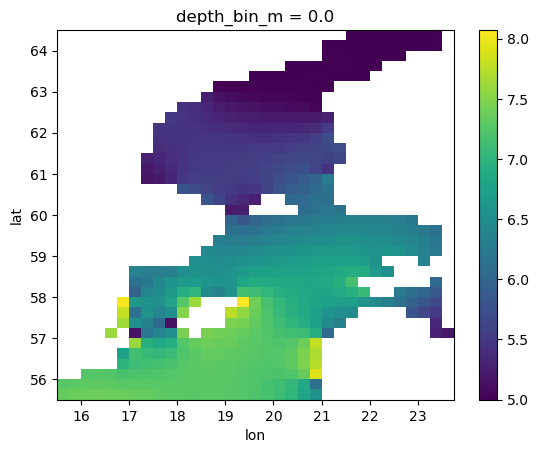

In [186]:
woa_da.isel(depth_bin_m = 0).plot()

This is exactly as we expected for our region of interest. We can now interpolate the data in the WOA data to match the GFDL data. First, we start matching the depth bins.

In [187]:
woa_da = woa_da.interp({'depth_bin_m': gfdl_mean.depth_bin_m.values})
woa_da

<xarray.DataArray (depth_bin_m: 35, lat: 36, lon: 33)> Size: 333kB
array([[[7.35010004, 7.37039495, 7.38519001, ...,        nan,
                nan,        nan],
        [7.25470495, 7.29038978, 7.32029986, ...,        nan,
                nan,        nan],
        [       nan,        nan, 7.2739501 , ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ..., 4.9998951 ,
         4.9998951 ,        nan],
        [       nan,        nan,        nan, ..., 5.00269985,
         5.00239992,        nan]],

       [[7.35248995, 7.37380981, 7.40080023, ...,        nan,
                nan,        nan],
        [7.26500988, 7.28939009, 7.33549976, ...,        nan,
                nan,        nan],
        [       nan,        nan, 7.30829   , ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * lon          (lon) float32 132B 15.62 15.88 16.12 ... 23.12 23.38 23.62
  * lat          (lat) float64 288B 55.62 55.88 56.12 ... 63.88 64.12 64.38
  * depth_bin_m  (depth_bin_m) float64 280B 2.5 10.0 20.0 ... 6e+03 6.5e+03

We now have 35 depth bins matching the GFDL data. We can continue with the regridding step. We will use the `xesmf` package to do this. You can refer to the [documentation](https://xesmf.readthedocs.io/en/stable/user_api.html#regridder) to see all available regridding methods.  

Remember, in this regridding function, you will need to provide the variable you want to regrid (`ds_in`) and then provide your target grid (`ds_out`). 

In [190]:
regridder = xe.Regridder(ds_in = woa_da, ds_out = gfdl_mean, method = 'bilinear')
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_36x33_36x33.nc 
Reuse pre-computed weights? False 
Input grid shape:           (36, 33) 
Output grid shape:          (36, 33) 
Periodic in longitude?      False

We can now apply the regridder.

In [191]:
woa_reg = regridder(woa_da)
woa_reg

<xarray.DataArray (depth_bin_m: 35, lat: 36, lon: 33)> Size: 333kB
array([[[       nan,        nan,        nan, ..., 5.00269985,
         5.00239992,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [7.25470495, 7.29038978, 7.32029986, ...,        nan,
                nan,        nan],
        [7.35010004, 7.37039495, 7.38519001, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ..., 5.00259018,
         5.00220013,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * depth_bin_m  (depth_bin_m) float64 280B 2.5 10.0 20.0 ... 6e+03 6.5e+03
  * lat          (lat) float64 288B 64.38 64.12 63.88 ... 56.12 55.88 55.62
  * lon          (lon) float64 264B 15.62 15.88 16.12 ... 23.12 23.38 23.62
Attributes:
    regrid_method:  bilinear

We will add a name to our data frame so we know what information is contained in this variable.

In [198]:
woa_reg.name = 'salinity'
woa_reg

<xarray.DataArray 'salinity' (depth_bin_m: 35, lat: 36, lon: 33)> Size: 333kB
array([[[       nan,        nan,        nan, ..., 5.00269985,
         5.00239992,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [7.25470495, 7.29038978, 7.32029986, ...,        nan,
                nan,        nan],
        [7.35010004, 7.37039495, 7.38519001, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ..., 5.00259018,
         5.00220013,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * depth_bin_m  (depth_bin_m) float64 280B 2.5 10.0 20.0 ... 6e+03 6.5e+03
  * lat          (lat) float64 288B 64.38 64.12 63.88 ... 56.12 55.88 55.62
  * lon          (lon) float64 264B 15.62 15.88 16.12 ... 23.12 23.38 23.62
Attributes:
    regrid_method:  bilinear

We can also check the result by plotting the first depth bin of the regridded `Data Array`.

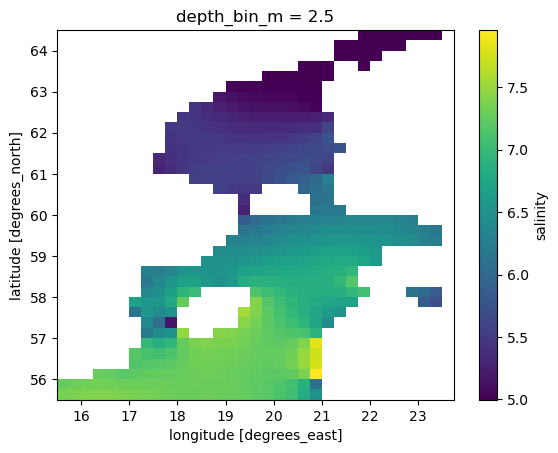

In [199]:
woa_reg.isel(depth_bin_m = 0).plot()

You can save the regridded `Data Array` in the file format of your choice. If you want to save this as gridded data, you could simply use:  
- For `netcdf`: `woa_reg.to_netcdf('file_path.nc')`  
- For `zarr`: `woa_reg.to_zarr('file_path.zarr')`
  
Make sure you include the correct file extension when saving the variable.  
  
You can also save the results as a data frame, which requires you to convert the `Data Array` to a `data frame` before saving the data.

In [205]:
woa_df = woa_reg.to_dataframe().reset_index()
woa_df.head()

,depth_bin_m,lat,lon,salinity
0,2.5,64.375,15.625,NaN
1,2.5,64.375,15.875,NaN
2,2.5,64.375,16.125,NaN
3,2.5,64.375,16.375,NaN
4,2.5,64.375,16.625,NaN


Now we can save the result as either:  
- `csv`: `woa_df.to_csv('file_path.csv')`  
- `parquet`: `woa_df.to_parquet('file_path.parquet')`  

Once again, you need to make sure you include the correct file extension when saving the data.